<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/chmntz_Lab5/Lab5/chmntz_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Differential Equations**
Carl **Chemnitz**

# **Abstract**
In this lab, differential equations will be discussed and how they can be solved numerically. We will focus heavily on Heun's method, the theory behind it and how it can be implemented. We will also discuss stability and accuracy of the method.

# **Set up environment**
To have access to the neccessary modules you have to run this cell.

In [818]:
import sympy as sym
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from IPython.display import Markdown
from typing import Callable
from matplotlib import tri, axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**
An initial value problem (IVP) is a defined as a differential equation $f:\mathbb{R}\times\mathbb{R}^n\rightarrow\mathbb{R}^n$,
$$\dot{u}(t)=f(u(t),t),$$
and an initial condition
$$u(0)=u_0.$$
They are generally solved by approximating the solutions by *time stepping*. Time stepping is the idea of computing successive approximations $U(t_n)$ on the time interval $t\in[0,T]$ starting at $U(t_0)=u_0$. There are multiple methods of time stepping such as *explicit Euler method* (forward), *implicit Euler method* (backward) and *$\theta$-method*.

In this lab, the two mandatory assignments will be implementing **Heun's method** which is a predictor-corrector method. It uses explicit Euler method,
$$\tilde{u}_{n+1}=u_n+hf(u_n,t_n),$$
to predict the next solution $\tilde{u}_{n+1}$ based on the previous solution $u_n$, and the trapezoidal method as the corrector step,
$$u_{n+1}=u_n+\frac{h}{2}\Big(f(u_n,t_n)+f(\tilde{u}_{n+1},t_{n+1})\Big).$$


# **Method**

## Time stepping for scalar IVP $\frac{du}{dt}=f(u,t)$
Implementing a time stepping function for scalar IVP we only have one function $f(u,t)$ to approximate. As stated in the introduction, Heun's method was implemented.

In [819]:
def heun_scalar(f: Callable, u0: float, t_max: float, n: int):
    t, u = 0, np.zeros(n)
    h = t_max / n
    u[0] = u0
    for i in range(1, len(u)):
        u[i] = u[i-1] + (h / 2) * (f(u[i-1], t) + f((u[i-1] + h * f(u[i-1], t+h)), t + h))
        t += h
    return u

## Time stepping for a system of IVP $\frac{du}{dt}=f(u,t)$

To modify the scalar implementation of Heun's method to be extended to systems of equations we have to modify it to allow an array of functions instead of a single function,
$$\dot{u}=\frac{du}{dt}=\Big(\frac{du_1}{dt},\dots,\frac{du_N}{dt}\Big)^T,$$
and take in an array of initial conditions instead of one,
$$u_0=(u_{1,0},\dots,u_{N,0})^T.$$

In [820]:
def heun_system(f: Callable, u0: np.array(2, dtype=float), t_max: float, n: int):
    dim = u0.shape[0]
    t, u = 0, np.zeros([n, dim])
    h = t_max / n
    u[0, :] = u0[:]
    for i in range(1, len(u)):
        u[i, :] = u[i-1, :] + (h / 2) * (f(u[i-1, :], t) + f((u[i-1, :] + h * f(u[i-1, :], t+h)), t + h))
        t += h
    return u

# **Results**

## Time stepping for scalar IVP
We begin by testing the implementation when solving a scalar IVP. We define a function
$$f(u,t)=-\sin(u)+\sqrt{t}.$$

In [821]:
f = lambda u, t : -np.sin(u) + np.sqrt(t)

We use the function $f$ to test the implemented method and compare it to `odeint` over the same interval $t\in[0,T]$ and amount of steps, using the same initial condition $u_0$. We assume that `odeint` is more accurate and calculate an approximation error over the interval.

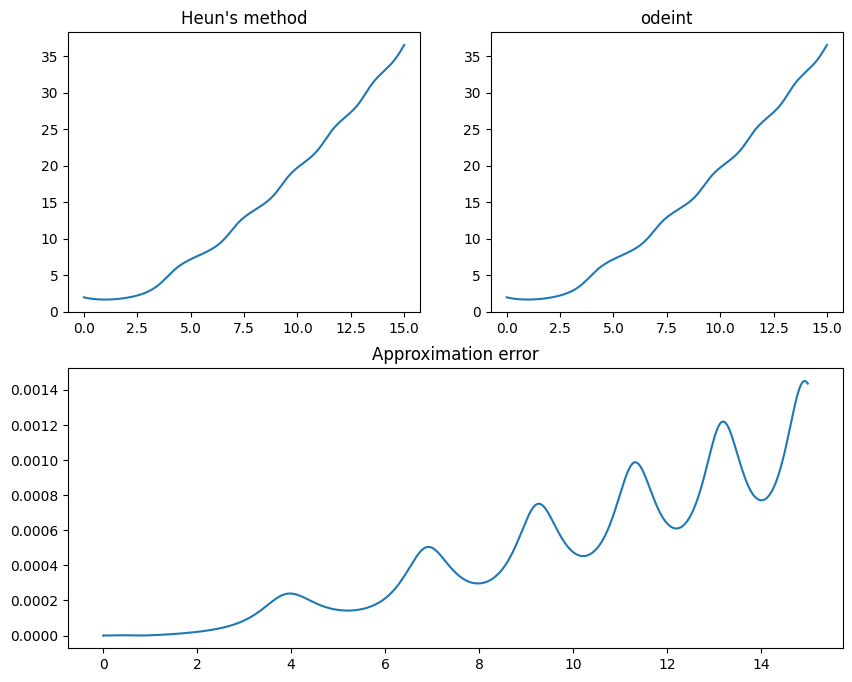

In [822]:
t = np.linspace(0, 15, 50000)
u_approx = heun_scalar(f, 2, 15, 50000)
u_exact = sp.integrate.odeint(f, 2, t)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221)
ax1.title.set_text("Heun's method")
ax1.plot(t, u_approx)
ax2 = fig.add_subplot(222)
ax2.title.set_text("odeint")
ax2.plot(t, u_exact)
ax3 = fig.add_subplot(212)
ax3.title.set_text("Approximation error")
diff = np.abs(u_approx - u_exact[:,0])
ax3.plot(t, diff)
fig.show()

We also compare how sensitive the initial condition is and how much it affects the end result $u(T)$. This is done, along with comparision between the exact solution and the approximated solution for a range of step sizes,

$$h=[1.0, 0.1, 0.01, 0.001, 0.0001].$$

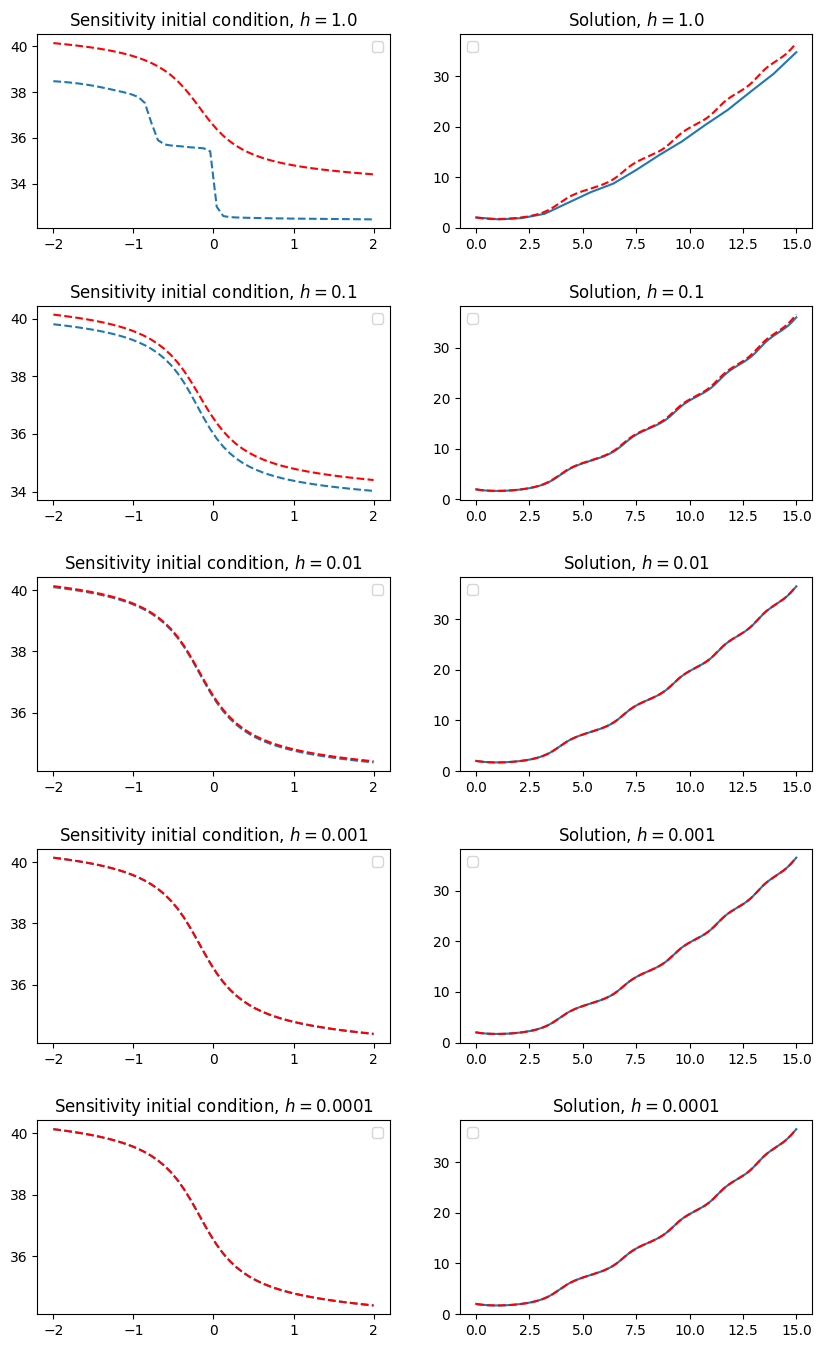

In [823]:
u_prop = np.linspace(-2, 2, 50)
t = np.linspace(0, 15, 400000)
u_exact = sp.integrate.odeint(f, 2, t)
u0_exact = []
for u in u_prop:
    u0_exact.append(sp.integrate.odeint(f, 2-u, t)[-1])
index = 1
fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.4)
for N in [15, 150, 1500, 15000, 150000]:
    u0 = []
    for u in u_prop:
        u0.append(heun_scalar(f, 2-u, 15, N)[-1])
    u_approx = heun_scalar(f, 2, 15, N)

    ax1 = fig.add_subplot(5,2,index)
    ax1.title.set_text(f"Sensitivity initial condition, $h=${15/N}")
    ax1.legend(["Approximate", "Exact solution"])
    ax1.plot(u_prop, u0, '--')
    ax1.plot(u_prop, u0_exact, 'r--')

    ax2 = fig.add_subplot(5,2,index+1)
    ax2.title.set_text(f"Solution, $h=${15/N}")
    ax2.legend(["Approximate", "Exact solution"])
    ax2.plot(np.linspace(0, 15, N), u_approx)
    ax2.plot(t, u_exact, 'r--')
    index += 2
fig.show()

## Time stepping for system of IVP

The predator-prey system of two species is a compartment model that can be solved using our implementation of Heun's method for systems of IVP. We create a random community matrix that describes the predator-prey relation between the species $u_1$ and $u_2$.

$$\begin{bmatrix}\dot{u}_1 \\ \dot{u}_2\end{bmatrix}=\begin{bmatrix}u_1(\alpha-\beta u_2)\\u_2(\delta u_1-\gamma)\end{bmatrix},$$

where $\alpha, \beta, \gamma, \delta>0$.

In [824]:
alpha, beta, gamma, delta = np.random.rand(4)
def predator_prey(U: np.array, t: float) -> np.array:
    u1 = U[0] * (alpha - beta * U[1])
    u2 = U[1] * (delta * U[0] - gamma)
    return np.array([u1, u2])

We know that the model will have 2 equilibrium points, an unstable point
$$u^{(1)}=(0,0)^T,$$
and a center point (neutral spiral)
$$u^{(2)}=(\gamma/\delta,\alpha/\beta)^T.$$

To read more about why, read example 14.10 in *Methods of Computational Science*. We plot the phase diagram and mark the center equilibrium point in red.

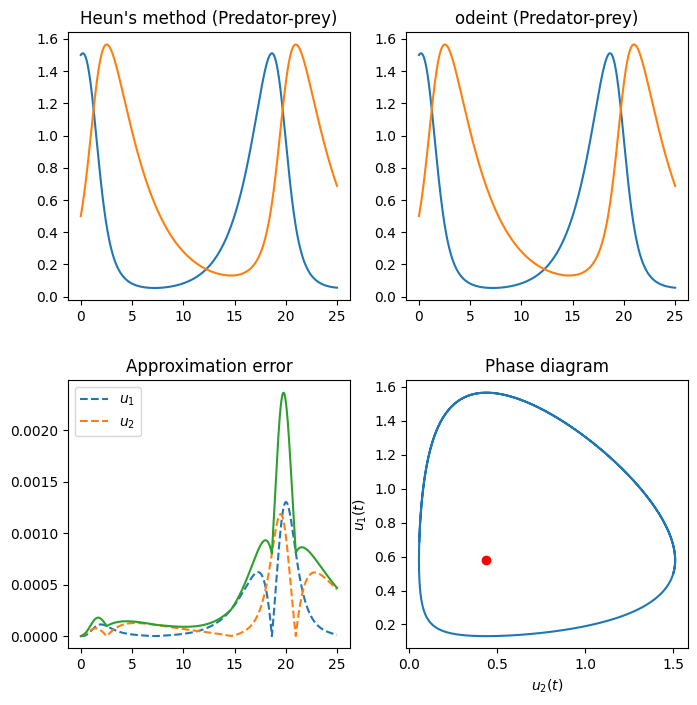

In [825]:
t = np.linspace(0, 25, 10000)
u_approx = heun_system(predator_prey, np.array([1.5, 0.5]), 25, 10000)
u_exact = sp.integrate.odeint(predator_prey, np.array([1.5, 0.5]), t)

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(221)
ax1.title.set_text("Heun's method (Predator-prey)")
ax1.plot(t, u_approx)
ax2 = fig.add_subplot(222)
ax2.title.set_text("odeint (Predator-prey)")
ax2.plot(t, u_exact)
ax3 = fig.add_subplot(223)
ax3.title.set_text("Approximation error")
diff = np.abs(u_approx[:] - u_exact[:,:])
diff_t = [np.sum(np.abs(u_approx[i, :] - u_exact[i, :])) for i in range(0, len(u_approx))]
ax3.plot(t, diff, '--')
ax3.plot(t, diff_t)
ax3.legend(['$u_1$', "$u_2$"])
ax4 = fig.add_subplot(224)
ax4.title.set_text("Phase diagram")
ax4.plot(u_approx[:,0], u_approx[:,1])
ax4.set_ylabel("$u_1(t)$")
ax4.set_xlabel("$u_2(t)$")
eqpoint_2 = sp.optimize.fsolve(predator_prey, np.array([gamma/delta,alpha/beta]), args=(0))
ax4.scatter(eqpoint_2[0], eqpoint_2[1], color='red')
fig.show()

The SIR model is a general epidemic model with the differential equations,

$$\begin{cases}
\dot{S}(t)=(1-V)\mu - \alpha I(t)S(t)-\mu S(t) \\
\dot{I}(t)=\alpha I(t)S(t)-(\gamma+\mu)I(t) \\
\dot{R}(t)=V\mu+\gamma I(t)-\mu R(t)
\end{cases}$$
as described in [this paper](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pamm.200701147).

$\mu$ is the death and birth rate, $\gamma$ is the recovery rate, $V$ is the vaccination rate and $\alpha$ is the transmission coefficient.

In [826]:
alpha, gamma, mu, V= 0.2, 0.05, 0.03, 0.1
def SIR(SIR: np.array, t: float) -> np.array:
    S = (1 - V) * mu - alpha * SIR[0] * SIR[1] - mu * SIR[0]
    I = alpha * SIR[0] * SIR[1] - (gamma + mu) * SIR[1]
    R = V * mu + gamma * SIR[1] - mu * SIR[2]
    return np.array([S, I, R])

The model was solved using our implementation of Heun's method for systems of IVP and `odeint` and then compared. The approximation error was then calculated and plotted for all point in $t\in[0,T]$.

The phase plots of the three compartments was constructed and then a 3D phase diagram was constructed with the two possible stable points plotted.

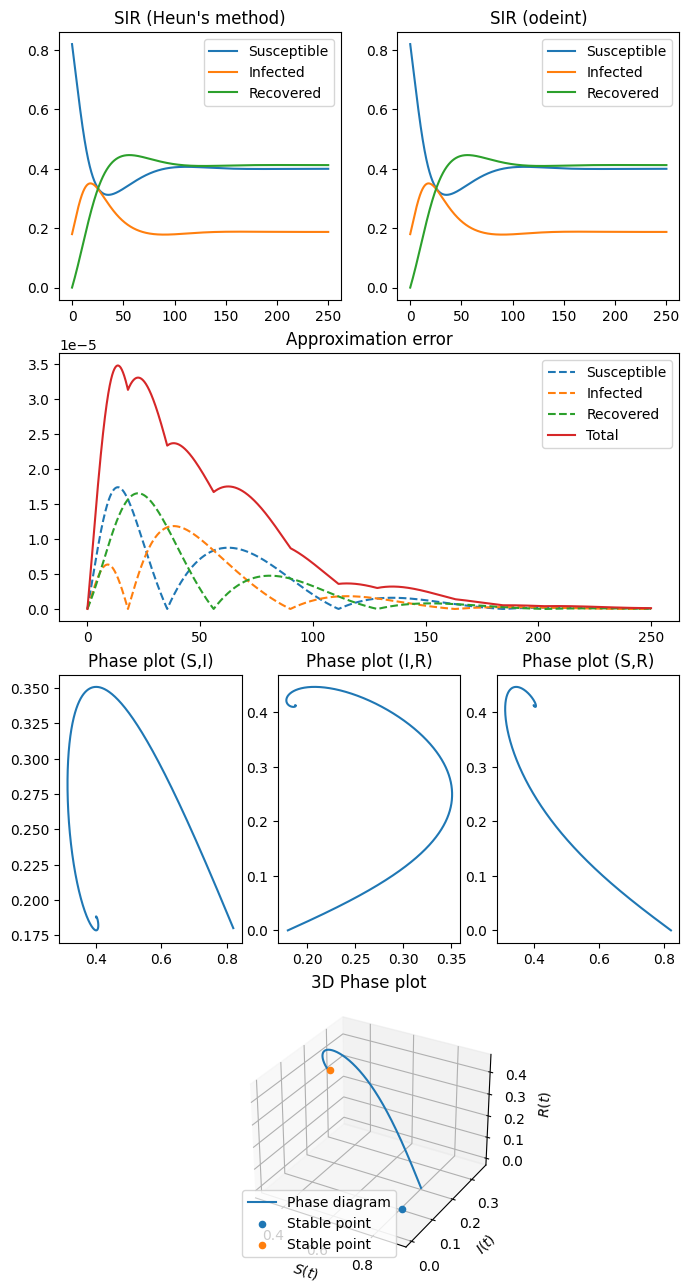

In [827]:
t = np.linspace(0, 250, 15000)
u_approx = heun_system(SIR, np.array([0.82, 0.18, 0.00]), 250, 15000)
u_exact = sp.integrate.odeint(SIR, np.array([0.82, 0.18, 0.00]), t)

fig = plt.figure(figsize=(8, 16))

ax1 = fig.add_subplot(421)
ax1.title.set_text("SIR (Heun's method)")
ax1.plot(t, u_approx)
ax1.legend(['Susceptible', 'Infected', 'Recovered'])

ax2 = fig.add_subplot(422)
ax2.title.set_text("SIR (odeint)")
ax2.plot(t, u_exact)
ax2.legend(['Susceptible', 'Infected', 'Recovered'])

ax3 = fig.add_subplot(412)
ax3.title.set_text("Approximation error")
diff = np.abs(u_approx[:] - u_exact[:,:])
diff_t = [np.sum(np.abs(u_approx[i, :] - u_exact[i, :])) for i in range(0, len(u_approx))]
ax3.plot(t, diff, '--')
ax3.plot(t, diff_t)
ax3.legend(['Susceptible', 'Infected', 'Recovered', 'Total'])

ax4 = fig.add_subplot(414, projection = '3d')
ax4.title.set_text("3D Phase plot")
ax4.plot(u_approx[:,0], u_approx[:,1], u_approx[:,2])
ax4.scatter(0.9, 0.0, 0.1, 'r')
ax4.scatter(0.4, 0.1875, 0.4125, 'r')
ax4.set_xlabel("$S(t)$")
ax4.set_ylabel("$I(t)$")
ax4.set_zlabel("$R(t)$")
ax4.legend(["Phase diagram", "Stable point", "Stable point"])

ax5 = fig.add_subplot(437)
ax5.title.set_text("Phase plot (S,I)")
ax5.plot(u_approx[:,0], u_approx[:,1])

ax6 = fig.add_subplot(438)
ax6.title.set_text("Phase plot (I,R)")
ax6.plot(u_approx[:,1], u_approx[:,2])

ax7 = fig.add_subplot(439)
ax7.title.set_text("Phase plot (S,R)")
ax7.plot(u_approx[:,0], u_approx[:,2])

fig.show()

# **Discussion**
Firstly, only the implementation of Heun's method for systems of IVP could have been implemented and used to solve both scalar IVP and systems of IVPs. As the lab assignment was to implement two function, I chose to implement both variation of Heun's method.

I chose to assume `odeint` was more accurate than my implementation as it most likely used Runge-Kutte 4 algorithm or something more advanced and optimized. I could not be bothered to solve the differential equations analytically, even with the help of sympy as I did not find it necessary or had the time to do it.

Heun's method, as a predictor-corrector method did not have the same issues that more naive methods have, such as implicit or explicit Eular methods. The more naive methods tends to be less stable, particularly for stiff differential equations. However, the Eular method is less computational intensive, which is obvious as Heun's method is based on explicit Eular method.

I had a hard time of finding the equilibrium points of the SIR model but used `scipy.optimize.fsolve` to find the roots using different initial values to find the stable points presented in the results.